In [ ]:
!pip install soccerdata

In [ ]:
# БЛОК 1: ИМПОРТ БИБЛИОТЕК И НАСТРОЙКИ
import gdown  # для скачивания файлов с Google Drive
import pandas as pd  # для работы с таблицами
import numpy as np  # для математических операций
import re  # для работы с текстом
from pathlib import Path  # для работы с путями файлов
from sklearn.preprocessing import StandardScaler  # для нормализации данных
from sklearn.linear_model import LinearRegression  # линейные модели
from sklearn.metrics import mean_absolute_error, r2_score  # метрики качества
import zipfile  # для работы с архивами
import os  # для работы с файловой системой
from tabulate import tabulate  # для красивых таблиц
import warnings  # для управления предупреждениями
import matplotlib.pyplot as plt
from tqdm import tqdm
import soccerdata as sd
import joblib

# Отключаем предупреждения чтобы не засорять вывод
warnings.filterwarnings('ignore')

# Настраиваем отображение таблиц
pd.set_option('display.max_columns', None)  # показывать все колонки
pd.set_option('display.width', 1000)  # ширина таблицы

print("✅ Библиотеки загружены и настроены")

✅ Библиотеки загружены и настроены


In [ ]:
# БЛОК 2: ЗАГРУЗКА ФУТБОЛЬНЫХ ДАННЫХ
def load_football_data(num_seasons=6):
    """Загружает данные о матчах"""
    print(f"📥 Загружаем {num_seasons} сезонов...")

    # Скачиваем архив с данными
    epl_url = 'https://drive.google.com/uc?id=1O8t5XkJDAC_aBtNjadiyv3aHZVNGdxFo'
    epl_filename = gdown.download(epl_url, quiet=True)
    # Проверяем, что файл скачался
    if not os.path.exists(epl_filename):
        print("❌ Файл не скачался")
        return pd.DataFrame()

    # Распаковываем архив
    with zipfile.ZipFile(epl_filename, 'r') as zip_ref:
        zip_ref.extractall('/content/data')

    # Удаляем архив
    os.remove(epl_filename)

    # Ищем все CSV файлы в папке
    DATASET_DIR = 'data/EPL/'
    csv_files = list(Path(DATASET_DIR).glob('*.csv'))

    all_dfs = []  # список для всех таблиц

    # Обрабатываем каждый файл
    for csv_file in csv_files:
        try:
            # Читаем CSV файл с обработкой ошибок (упрощенная версия)
            df_temp = pd.read_csv(
                csv_file,
                encoding='latin-1',
                on_bad_lines='skip',  # Пропускаем проблемные строки
                engine='python'       # Используем Python парсер вместо C
            )

             # Выбираем только нужные колонки, если они есть
            available_cols = [col for col in ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
                                if col in df_temp.columns]
            df_temp = df_temp[available_cols]
              # ИСoПРАВЛЕНИЕ: Преобразуем название сезона, добавляя "19" или "20"
            season = csv_file.stem  # Например, "95-96" или "23-24"
            first_year = int(season.split('-')[0])  # Извлекаем первую часть (например, 95 или 23)
            if 90 <= first_year <= 99:
                full_season = f"19{season}"  # Добавляем "19" для 90-х (например, "1995-1996")
            else:
                full_season = f"20{season}"  # Добавляем "20" для 2000-х и позже (например, "2023-2024")
            df_temp['season'] = full_season  # Присваиваем полное название сезона
            all_dfs.append(df_temp)

        except Exception as e:
            print(f"   ❌ Ошибка чтения файла {csv_file}: {e}")
            continue

    # Проверяем, что загрузили хоть что-то
    if not all_dfs:
        print("❌ Не удалось загрузить данные - нет подходящих файлов")
        return pd.DataFrame()

    # Объединяем все таблицы в одну
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Получаем список сезонов и сортируем по убыванию (от новых к старым)
    seasons = sorted([s for s in combined_df['season'].unique() if s], reverse=True)

    # Если запросили больше сезонов, чем есть, берём все доступные
    if num_seasons > len(seasons):
        num_seasons = len(seasons)

    # Выбираем нужное количество сезонов
    selected_seasons = seasons[:num_seasons]
    df = combined_df[combined_df['season'].isin(selected_seasons)].copy()

    def parse_date(date_str):
        """Парсит дату из разных форматов"""
        # Пробуем разные форматы дат
        for fmt in ['%d/%m/%Y', '%d/%m/%y', '%Y-%m-%d', '%d.%m.%Y']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.NaT  # если ни один формат не подошел

    # Конвертируем даты
    df['Date'] = df['Date'].astype(str).apply(parse_date)

    # Удаляем строки без даты и сортируем
    df = df.dropna(subset=['Date']).sort_values('Date')

    print(f"✅ Загружено {len(df)} матчей")
    return df


In [ ]:
# БЛОК 3: ЗАГРУЗКА РЕЙТИНГА ЭЛО
# ГЛОБАЛЬНЫЙ СЛОВАРЬ МАППИНГА КОМАНД
TEAM_NAME_MAPPING = {
    # названия в списке матчей -> названия в матчах ELO
    "Nott'm Forest": 'Forest'
}

def normalize_team_name(team_name, mapping=TEAM_NAME_MAPPING):
    """Нормализует название команды согласно маппингу"""
    return mapping.get(team_name, team_name)

def load_all_elo_ratings(matches_df, days_before=120):
    """
    Загружает ELO-рейтинги для всех уникальных команд в датафрейме матчей. Days_before - чтобы исключить проблему отсутствия рейтинга в начале сезона
    """
    # 1. Находим уникальные команды и диапазон дат
    all_teams = pd.concat([matches_df['HomeTeam'], matches_df['AwayTeam']]).unique()
    min_date = matches_df['Date'].min()
    max_date = matches_df['Date'].max()
    min_date_with_buffer = min_date - pd.Timedelta(days=days_before)

    print(f"Найдено уникальных команд: {len(all_teams)}")
    print(f"Диапазон дат матчей: {min_date} - {max_date}")

    # 2. Инициализируем загрузчик ELO
    elo_loader = sd.ClubElo()

    # 3. Загружаем историю для каждой команды
    elo_data = {}
    unfound_teams = []
    found_teams = []

    for original_team in tqdm(all_teams, desc="Загрузка ELO"):
        # Нормализуем название для ELO
        elo_team_name = normalize_team_name(original_team)

        try:
            team_history = elo_loader.read_team_history(elo_team_name)

            # Фильтруем период
            team_history = team_history[
                (team_history.index >= min_date_with_buffer) &
                (team_history.index <= max_date)
            ]

            if not team_history.empty:
                elo_data[original_team] = team_history
                found_teams.append(original_team)

            else:
                print(f"⚠️ Нет данных ELO для {original_team} (искали как '{elo_team_name}')")
                unfound_teams.append(original_team)

        except Exception as e:
            print(f"❌ Ошибка загрузки {original_team} (искали как '{elo_team_name}'): {e}")
            unfound_teams.append(original_team)

    print(f"\n✅ Успешно загружено: {len(elo_data)} команд")
    if unfound_teams:
        print(f"❌ Не найдено: {len(unfound_teams)} команд: {unfound_teams}")

    return elo_data

def convert_elo_dict_to_dataframe_detailed(elo_data):
    """Конвертирует словарь ELO данных в DataFrame"""

    all_elo_records = []

    for team_name, team_history in elo_data.items():
        if team_history is not None and not team_history.empty:
            # Сбрасываем индекс чтобы получить дату как колонку
            team_df = team_history.reset_index()
            team_df['team'] = team_name

            # Ищем колонку с датой
            date_col = None
            for col in team_df.columns:
                if col.lower() in ['date', 'index', 'level_0']:
                    date_col = col
                    break

            if date_col:
                team_df = team_df.rename(columns={date_col: 'Date'})
            else:
                team_df['Date'] = team_df.index

            all_elo_records.append(team_df)

    if not all_elo_records:
        print("❌ Нет ELO данных для конвертации")
        return pd.DataFrame()

    # Объединяем все записи
    elo_df = pd.concat(all_elo_records, ignore_index=True)

    # Проверяем наличие колонки 'Date'
    date_column = None
    for col in elo_df.columns:
        if col.lower() in ['date', 'index']:
            date_column = col
            break

    if date_column and date_column != 'Date':
        elo_df = elo_df.rename(columns={date_column: 'Date'})

    # Оставляем только нужные колонки
    required_cols = ['Date', 'team', 'elo']
    available_cols = [col for col in required_cols if col in elo_df.columns]

    if len(available_cols) < 3:
        print(f"❌ Не хватает обязательных колонок. Доступны: {list(elo_df.columns)}")
        return pd.DataFrame()

    elo_df = elo_df[available_cols]

    # Убедимся что дата в правильном формате
    print(f"✅ Создан DataFrame с {len(elo_df)} записями ELO для {len(elo_data)} команд")
    return elo_df

def merge_matches_with_elo_optimized(all_matches, elo_df):
    """Оптимизированное объединение для больших объемов данных с маппингом названий"""

    # Конвертируем даты
    all_matches['Date'] = pd.to_datetime(all_matches['Date'])
    elo_df['Date'] = pd.to_datetime(elo_df['Date'])

    # ПРИМЕНЯЕМ МАППИНГ К ELO ДАННЫМ
    elo_df_mapped = elo_df.copy()
    elo_df_mapped['team'] = elo_df_mapped['team'].apply(normalize_team_name)

    # Сортируем ELO данные
    elo_df_mapped = elo_df_mapped.sort_values(['team', 'Date'])

    # Создаем словарь для быстрого доступа к последним ELO
    elo_dict = {}
    for team in elo_df_mapped['team'].unique():
        team_data = elo_df_mapped[elo_df_mapped['team'] == team].set_index('Date')['elo']
        elo_dict[team] = team_data

    # ДИАГНОСТИКА: покажем какие команды есть в словаре
    def get_elo_fast(team, match_date):
        """Быстрый поиск ELO через словарь с маппингом названий"""
        # Нормализуем название команды для поиска в ELO данных
        elo_team_name = normalize_team_name(team)

        if elo_team_name in elo_dict:
            team_elo = elo_dict[elo_team_name]
            # Находим последнюю дату до матча
            available_dates = team_elo.index[team_elo.index <= match_date]
            if len(available_dates) > 0:
                last_date = available_dates[-1]
                elo_value = team_elo[last_date]
                return elo_value
            else:
                # Если нет данных ДО матча, используем среднее команды
                team_avg = team_elo.mean()
                print(f"⚠️ Нет свежих ELO данных для {team} на {match_date}, используем среднее команды: {team_avg:.1f}")
                return team_avg
        else:
            # Если команды вообще нет в ELO данных, используем общее среднее
            avg_elo = elo_df_mapped['elo'].mean()
            print(f"❌ Нет ELO данных для {team} (искали как '{elo_team_name}'), используем общее среднее: {avg_elo:.1f}")
            return avg_elo

    # Добавляем ELO рейтинги
    print("📊 Добавляем ELO домашних команд...")
    matches_with_elo = all_matches.copy()

    # Теперь применяем ко всем матчам
    matches_with_elo['Home_ELO'] = matches_with_elo.apply(
        lambda row: get_elo_fast(row['HomeTeam'], row['Date']),
        axis=1
    )

    print("📊 Добавляем ELO гостевых команд...")
    matches_with_elo['Away_ELO'] = matches_with_elo.apply(
        lambda row: get_elo_fast(row['AwayTeam'], row['Date']),
        axis=1
    )

    # Дополнительные признаки на основе ELO
    matches_with_elo['ELO_Difference'] = matches_with_elo['Home_ELO'] - matches_with_elo['Away_ELO']

    return matches_with_elo

In [ ]:
# БЛОК 4: СОЗДАНИЕ ПРИЗНАКОВ
def create_comprehensive_features(df, elo_df):
    """Создает признаки для нейросети, включая статистику за последние матчей"""
    print("🔄 Создаем признаки...")

    # Проверяем что данные не пустые
    if df.empty:
        return pd.DataFrame()

    # ОБЪЕДИНЯЕМ С ELO
    df_with_elo = merge_matches_with_elo_optimized(df, elo_df)

    if df_with_elo is None:
        print("❌ Не удалось объединить с ELO данными")
        return pd.DataFrame()

    # Создаем копию и сортируем по дате
    df_clean = df_with_elo.copy().sort_values('Date')

    results = []  # список для хранения признаков

    def calculate_team_efficiency(team, season, date, df):
      """Рассчитывает эффективность команды дома и в гостях"""
      home_matches = df[
          (df['HomeTeam'] == team) &
          (df['season'] == season) &
          (df['Date'] < date)
      ]

      away_matches = df[
          (df['AwayTeam'] == team) &
          (df['season'] == season) &
          (df['Date'] < date)
      ]

      home_ppg = 0
      away_ppg = 0

      if len(home_matches) > 0:
          home_points = 0
          for _, hm in home_matches.iterrows():
              if hm['FTHG'] > hm['FTAG']:
                  home_points += 3
              elif hm['FTHG'] == hm['FTAG']:
                  home_points += 1
          home_ppg = home_points / len(home_matches)

      if len(away_matches) > 0:
          away_points = 0
          for _, am in away_matches.iterrows():
              if am['FTAG'] > am['FTHG']:
                  away_points += 3
              elif am['FTAG'] == am['FTHG']:
                  away_points += 1
          away_ppg = away_points / len(away_matches)

      return home_ppg, away_ppg


    # Обрабатываем каждый матч
    for _, match in df_clean.iterrows():
        home_team = match['HomeTeam']  # домашняя команда
        away_team = match['AwayTeam']  # гостевая команда
        date = match['Date']           # дата матча
        season = match['season']       # сезон

        # ИНИЦИАЛИЗАЦИЯ ПЕРЕМЕННЫХ ДЛЯ ПРИЗНАКОВ
        home_goals_for = 0
        home_goals_against = 0
        home_points = 0
        away_goals_for = 0
        away_goals_against = 0
        away_points = 0
        h2h_home_avg = 0
        h2h_away_avg = 0
        form_difference = 0

        try:
            # ФОРМА КОМАНД (ТОЛЬКО ТЕКУЩИЙ СЕЗОН) - для Form Difference
            # Находим предыдущие матчи домашней команды в текущем сезоне
            home_prev_matches = df_clean[
                (df_clean['HomeTeam'] == home_team) | (df_clean['AwayTeam'] == home_team)
            ]
            home_prev_matches = home_prev_matches[home_prev_matches['Date'] < date]
            home_prev_matches = home_prev_matches[home_prev_matches['season'] == season]

            if len(home_prev_matches) > 0:
                # Берем последние 5 матчей
                home_prev_matches = home_prev_matches.tail(5)

                # Считаем показатели формы
                for _, prev_match in home_prev_matches.iterrows():
                    if prev_match['HomeTeam'] == home_team:
                        home_goals_for += prev_match['FTHG']
                        home_goals_against += prev_match['FTAG']
                        if prev_match['FTHG'] > prev_match['FTAG']:
                            home_points += 3
                        elif prev_match['FTHG'] == prev_match['FTAG']:
                            home_points += 1
                    else:  # команда была гостем
                        home_goals_for += prev_match['FTAG']
                        home_goals_against += prev_match['FTHG']
                        if prev_match['FTAG'] > prev_match['FTHG']:
                            home_points += 3
                        elif prev_match['FTAG'] == prev_match['FTHG']:
                            home_points += 1

            # Аналогично для гостевой команды
            away_prev_matches = df_clean[
                (df_clean['HomeTeam'] == away_team) | (df_clean['AwayTeam'] == away_team)
            ]
            away_prev_matches = away_prev_matches[away_prev_matches['Date'] < date]
            away_prev_matches = away_prev_matches[away_prev_matches['season'] == season]

            if len(away_prev_matches) > 0:
                away_prev_matches = away_prev_matches.tail(5)

                for _, prev_match in away_prev_matches.iterrows():
                    if prev_match['HomeTeam'] == away_team:
                        away_goals_for += prev_match['FTHG']
                        away_goals_against += prev_match['FTAG']
                        if prev_match['FTHG'] > prev_match['FTAG']:
                            away_points += 3
                        elif prev_match['FTHG'] == prev_match['FTAG']:
                            away_points += 1
                    else:
                        away_goals_for += prev_match['FTAG']
                        away_goals_against += prev_match['FTHG']
                        if prev_match['FTAG'] > prev_match['FTHG']:
                            away_points += 3
                        elif prev_match['FTAG'] == prev_match['FTHG']:
                            away_points += 1

            # ИСТОРИЯ ЛИЧНЫХ ВСТРЕЧ (ВСЕ СЕЗОНЫ)
            h2h_matches = df_clean[
                ((df_clean['HomeTeam'] == home_team) & (df_clean['AwayTeam'] == away_team)) |
                ((df_clean['HomeTeam'] == away_team) & (df_clean['AwayTeam'] == home_team))
            ]
            h2h_matches = h2h_matches[h2h_matches['Date'] < date]

            if len(h2h_matches) > 0:
                h2h_home_goals = []
                h2h_away_goals = []

                for _, h2h_match in h2h_matches.iterrows():
                    if h2h_match['HomeTeam'] == home_team:
                        h2h_home_goals.append(h2h_match['FTHG'])
                        h2h_away_goals.append(h2h_match['FTAG'])
                    else:
                        h2h_home_goals.append(h2h_match['FTAG'])
                        h2h_away_goals.append(h2h_match['FTHG'])

                h2h_home_avg = np.mean(h2h_home_goals) if h2h_home_goals else 0
                h2h_away_avg = np.mean(h2h_away_goals) if h2h_away_goals else 0

            # Разница в форме команд
            form_difference = home_points - away_points

        except Exception as e:
            print(f"⚠️ Ошибка при вычислении признаков для матча {home_team} vs {away_team}: {e}")
            # Продолжаем с значениями по умолчанию

        # Создаем словарь с признаками
        features = {
            'Date': date,
            'HomeTeam': home_team,
            'AwayTeam': away_team,
            'FTHG': match['FTHG'],  # голы домашней (целевая переменная)
            'FTAG': match['FTAG'],  # голы гостевой (целевая переменная)
            'season': season,

            # Форма команд (ТОЛЬКО ТЕКУЩИЙ СЕЗОН)
            'Home_Form_Goals_For': home_goals_for,
            'Home_Form_Goals_Against': home_goals_against,
            'Away_Form_Goals_For': away_goals_for,
            'Away_Form_Goals_Against': away_goals_against,

            # История личных встреч (ВСЕ СЕЗОНЫ)
            'H2H_Home_Avg': h2h_home_avg,
            'H2H_Away_Avg': h2h_away_avg,

            # ELO признаки (ВСЕГДА ДОБАВЛЯЕМ)
            'ELO_Difference': match['ELO_Difference'],

            # Относительная сила (ТЕКУЩИЙ СЕЗОН)
            'Form_Difference': form_difference,
        }

        # Добавляем признаки в список
        results.append(features)

    # Создаем DataFrame из списка признаков
    features_df = pd.DataFrame(results)

    # Добавляем производные признаки
    features_df['Goal_Difference_Ratio'] = features_df['Home_Form_Goals_For'] / (features_df['Away_Form_Goals_For'] + 0.1)


    print(f"✅ Создано {len(features_df)} матчей с {len(features_df.columns)-5} признаками")

    return features_df

In [ ]:
# БЛОК 5: ПОДГОТОВКА ДАННЫХ
def prepare_football_data(features_df):
    """Подготавливает данные для обучения модели"""
    print("🔧 Подготавливаем данные...")

    # Колонки которые нужно удалить (не признаки)
    base_drop = ['Date', 'HomeTeam', 'AwayTeam', 'season', 'FTHG', 'FTAG']

    # Удаляем базовые колонки (оставляем только признаки)
    X = features_df.drop([col for col in base_drop if col in features_df.columns], axis=1)

    # Оставляем только числовые колонки
    X = X.select_dtypes(include=[np.number])

    # Целевые переменные - голы домашней и гостевой команд
    y_home = features_df['FTHG']
    y_away = features_df['FTAG']

    print(f"   Признаков: {X.shape[1]}, матчей: {X.shape[0]}")
    print(f"   Диапазон голов домашней: {y_home.min()}-{y_home.max()}")
    print(f"   Диапазон голов гостевой: {y_away.min()}-{y_away.max()}")

    # Разделяем данные по времени (временные ряды)
    dates = features_df['Date'].sort_values()  # сортируем даты
    split_idx = int(len(dates) * 0.8)          # 80% для обучения
    split_date = dates.iloc[split_idx]         # дата разделения

    # Создаем маски для разделения
    train_mask = features_df['Date'] < split_date   # маска для тренировочных данных
    test_mask = features_df['Date'] >= split_date   # маска для тестовых данных

    # Разделяем данные
    X_train, X_test = X[train_mask], X[test_mask]
    y_train_home, y_test_home = y_home[train_mask], y_home[test_mask]
    y_train_away, y_test_away = y_away[train_mask], y_away[test_mask]

    # Масштабируем признаки (приводим к одинаковому масштабу)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # обучаем scaler на тренировочных данных
    X_test_scaled = scaler.transform(X_test)        # применяем к тестовым данным

    print(f"✅ Обучающая: {X_train.shape}, Тестовая: {X_test.shape}")
    print(f"✅ Диапазон голов в обучающей: {y_train_home.min()}-{y_train_home.max()}")
    print(f"✅ Диапазон голов в тестовой: {y_test_home.min()}-{y_test_home.max()}")

    # Возвращаем подготовленные данные
    return X_train_scaled, X_test_scaled, y_train_home, y_test_home, y_train_away, y_test_away, scaler, X.columns


In [ ]:
def calculate_outcome_accuracy(pred_home, pred_away, actual_home, actual_away):
    """Вычисляет точность предсказания исходов (П1/Н/П2)"""
    pred_outcomes = np.where(pred_home > pred_away, 1,
                           np.where(pred_home < pred_away, -1, 0))
    actual_outcomes = np.where(actual_home > actual_away, 1,
                             np.where(actual_home < actual_away, -1, 0))

    return np.mean(pred_outcomes == actual_outcomes)

def calculate_total_accuracy(pred_home, pred_away, actual_home, actual_away, threshold=2.5):
    """Вычисляет точность предсказания тоталов"""
    pred_total = pred_home + pred_away
    actual_total = actual_home + actual_away

    pred_over = pred_total > threshold
    actual_over = actual_total > threshold

    return np.mean(pred_over == actual_over)

def calculate_btts_accuracy(pred_home, pred_away, actual_home, actual_away):
    """Вычисляет точность предсказания 'обе забьют'"""
    # Используем порог 0.5 для предсказаний (так как это непрерывные значения)
    pred_btts = (pred_home > 0.5) & (pred_away > 0.5)
    # Для фактических данных используем порог 1 (минимум 1 гол)
    actual_btts = (actual_home >= 1) & (actual_away >= 1)

    return np.mean(pred_btts == actual_btts)


def process_predictions_and_metrics(name, pred_home, pred_away, y_test_home, y_test_away, predictions, results, trained_models):
    """Обрабатывает предсказания и вычисляет метрики"""
    # Базовые метрики
    home_r2 = r2_score(y_test_home, pred_home)
    away_r2 = r2_score(y_test_away, pred_away)
    home_mae = mean_absolute_error(y_test_home, pred_home)
    away_mae = mean_absolute_error(y_test_away, pred_away)

    # Accuracy для betting-маркетов
    outcome_accuracy = calculate_outcome_accuracy(pred_home, pred_away, y_test_home, y_test_away)
    total_25_accuracy = calculate_total_accuracy(pred_home, pred_away, y_test_home, y_test_away, threshold=2.5)
    total_35_accuracy = calculate_total_accuracy(pred_home, pred_away, y_test_home, y_test_away, threshold=3.5)
    total_45_accuracy = calculate_total_accuracy(pred_home, pred_away, y_test_home, y_test_away, threshold=4.5)
    btts_accuracy = calculate_btts_accuracy(pred_home, pred_away, y_test_home, y_test_away)

    # СОЗДАЕМ СЛОВАРЬ С ВСЕМИ МЕТРИКАМИ
    model_results = {
        'Model': name,
        'Home_R2': home_r2,
        'Away_R2': away_r2,
        'Avg_R2': (home_r2 + away_r2) / 2,
        'Home_MAE': home_mae,
        'Away_MAE': away_mae,
        'Avg_MAE': (home_mae + away_mae) / 2,
        'Outcome_Accuracy': outcome_accuracy,
        'Total_25_Accuracy': total_25_accuracy,
        'Total_35_Accuracy': total_35_accuracy,
        'Total_45_Accuracy': total_45_accuracy,
        'BTTS_Accuracy': btts_accuracy
    }

    # ДОБАВЛЯЕМ В РЕЗУЛЬТАТЫ
    results.append(model_results)

    predictions['home'][name] = pred_home
    predictions['away'][name] = pred_away


In [ ]:
# БЛОК 7: ОБУЧЕНИЕ МОДЕЛИ
def train_football_models(X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away, scaler):
    """Обучает линейную регрессию для прогнозирования голов"""
    print("🤖 Обучаем модель Linear Regression...")

    # Создаем папку для сохранения модели
    os.makedirs('saved_models', exist_ok=True)
    results = []
    predictions = {'home': {}, 'away': {}}
    trained_models = {'home': {}, 'away': {}}

    # Обучаем классические модели
    try:
      print("\n--- Обучение модели: Linear Regression ---")

      # Модель для домашних голов
      model_home = LinearRegression()
      model_home.fit(X_train, y_train_home)
      pred_home = model_home.predict(X_test)

      # Модель для гостевых голов
      model_away = LinearRegression()
      model_away.fit(X_train, y_train_away)
      pred_away = model_away.predict(X_test)

          # Сохраняем обученные модели
      trained_models['home']['Linear Regression'] = model_home
      trained_models['away']['Linear Regression'] = model_away

      # Обработка предсказаний и метрик
      process_predictions_and_metrics('Linear Regression', pred_home, pred_away, y_test_home, y_test_away,
                                    predictions, results, trained_models)

    except Exception as e:
        print(f"   ❌ Linear Regression: {e}")


    # Функция для сохранения модели
    def save_models_with_scaler(trained_models, scaler):
        """Сохраняет модели и scaler"""
        print(f"\n💾 Сохраняем модели...")

        # Сохраняем scaler отдельно
        try:
            joblib.dump(scaler, 'saved_models/scaler.pkl')
            print(f"   ✅ Scaler сохранен")
        except Exception as e:
            print(f"   ❌ Ошибка сохранения scaler: {e}")

        # Сохраняем модели
        for name in trained_models['home'].keys():
          model_home = trained_models['home'][name]
          model_away = trained_models['away'][name]
          joblib.dump(model_home, f'saved_models/{name}_home.pkl')
          joblib.dump(model_away, f'saved_models/{name}_away.pkl')
          print(f"   ✅ {name} сохранена")


    # Вызываем функцию сохранения
    save_models_with_scaler(trained_models, scaler)

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)

    return results_df, trained_models, predictions




In [ ]:
# БЛОК 8: АНАЛИЗ РЕЗУЛЬТАТОВ
def analyze_feature_correlation_matrix(features_df, feature_names, correlation_threshold=0.8):
    """Анализирует корреляцию признаков между собой и с результатом"""
    print(f"\n{'='*80}")
    print("🔗 КОРРЕЛЯЦИЯ ПРИЗНАКОВ (ТОЛЬКО ТЕ, ЧТО ИСПОЛЬЗОВАЛИСЬ В МОДЕЛЯХ)")
    print(f"{'='*80}")

    # ИСПРАВЛЕНИЕ: используем ТОЛЬКО те признаки, которые были в обучении
    numeric_features = features_df[feature_names].select_dtypes(include=[np.number])

    if numeric_features.empty:
        print("❌ Нет числовых признаков для анализа")
        return

    print(f"📊 Анализируется {len(feature_names)} признаков, использованных в моделях:")
    for i, feature in enumerate(feature_names, 1):
        print(f"   {i:2d}. {feature}")

    # 1. ТОП-10 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ С РЕЗУЛЬТАТОМ
    print(f"\n🎯 ТОП-5 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ С РЕЗУЛЬТАТОМ")
    print("-" * 50)

    # Добавляем целевые переменные для анализа
    analysis_df = numeric_features.copy()
    analysis_df['FTHG'] = features_df['FTHG']  # голы домашней
    analysis_df['FTAG'] = features_df['FTAG']  # голы гостевой

    # Считаем среднюю корреляцию с обеими целевыми переменными
    feature_correlations = []
    for feature in feature_names:
        if feature in analysis_df.columns:
            # Средняя абсолютная корреляция с домашними и гостевыми голами
            avg_corr = np.mean([
                abs(analysis_df[feature].corr(analysis_df['FTHG'])),
                abs(analysis_df[feature].corr(analysis_df['FTAG']))
            ])
            # Фактическая корреляция (со знаком)
            home_corr = analysis_df[feature].corr(analysis_df['FTHG'])
            away_corr = analysis_df[feature].corr(analysis_df['FTAG'])

            feature_correlations.append({
                'Признак': feature,
                'Ср.корреляция': avg_corr,
                'Домашние': home_corr,
                'Гостевые': away_corr
            })

    # Сортируем по средней корреляции
    feature_correlations.sort(key=lambda x: x['Ср.корреляция'], reverse=True)

    # Выводим топ-10 лучших
    top_correlations = []
    for i, corr_data in enumerate(feature_correlations[:5]):
        home_sign = "🟢" if corr_data['Домашние'] > 0 else "🔴"
        away_sign = "🟢" if corr_data['Гостевые'] > 0 else "🔴"

        top_correlations.append([
            i+1,
            corr_data['Признак'],
            f"{corr_data['Ср.корреляция']:.4f}",
            f"{corr_data['Домашние']:.4f}{home_sign}",
            f"{corr_data['Гостевые']:.4f}{away_sign}"
        ])

    print(tabulate(top_correlations,
                  headers=['#', 'Признак', 'Ср.важность', 'Домашние', 'Гостевые'],
                  tablefmt='grid'))

    # 1.1 ХУДШИЕ ПРИЗНАКИ (КАНДИДАТЫ НА УДАЛЕНИЕ)
    print(f"\n📉 ХУДШИЕ ПРИЗНАКИ (КОРРЕЛЯЦИЯ < 0.05)")
    print("-" * 50)

    # Берем только признаки с корреляцией < 0.05
    worst_correlations = []
    for i, corr_data in enumerate(feature_correlations):
        if corr_data['Ср.корреляция'] < 0.05:
            home_sign = "🟢" if corr_data['Домашние'] > 0 else "🔴"
            away_sign = "🟢" if corr_data['Гостевые'] > 0 else "🔴"

            worst_correlations.append([
                i + 1,  # Позиция в общем рейтинге
                corr_data['Признак'],
                f"{corr_data['Ср.корреляция']:.4f}",
                f"{corr_data['Домашние']:.4f}{home_sign}",
                f"{corr_data['Гостевые']:.4f}{away_sign}",
                "❌ КАНДИДАТ НА УДАЛЕНИЕ"
            ])

    if worst_correlations:
        print(tabulate(worst_correlations,
                      headers=['#', 'Признак', 'Ср.важность', 'Домашние', 'Гостевые', 'Рекомендация'],
                      tablefmt='grid'))
    else:
        print("✅ Нет признаков с корреляцией < 0.05 - все признаки имеют хоть какое-то влияние")

    # 2. ТОП-5 ПРИЗНАКОВ, КОРРЕЛИРУЮЩИХСЯ ДРУГ С ДРУГОМ
    print(f"\n🔗 ТОП-5 ПАР КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ")
    print("-" * 50)

    # Считаем корреляционную матрицу
    corr_matrix = numeric_features.corr().round(4)

    # Находим все пары признаков
    all_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            # Исключаем пары с очень низкой корреляцией
            if abs(corr_matrix.iloc[i, j]) > 0.3:  # минимальный порог
                all_pairs.append({
                    'Признак 1': corr_matrix.columns[i],
                    'Признак 2': corr_matrix.columns[j],
                    'Корреляция': corr_matrix.iloc[i, j]
                })

    # Сортируем по абсолютной корреляции и берем топ-5
    all_pairs.sort(key=lambda x: abs(x['Корреляция']), reverse=True)
    top_pairs = all_pairs[:5]

    # Форматируем вывод
    pairs_display = []
    for i, pair in enumerate(top_pairs):
        strength = "🔴 ВЫСОКАЯ" if abs(pair['Корреляция']) > 0.7 else "🟡 СРЕДНЯЯ" if abs(pair['Корреляция']) > 0.5 else "🟢 СЛАБАЯ"
        pairs_display.append([
            i+1,
            pair['Признак 1'],
            pair['Признак 2'],
            f"{pair['Корреляция']:.4f}",
            strength
        ])

    print(tabulate(pairs_display,
                  headers=['#', 'Признак 1', 'Признак 2', 'Корреляция', 'Уровень'],
                  tablefmt='grid'))

    # Рекомендации
    print(f"\n💡 РЕКОМЕНДАЦИИ:")

    # Для сильно коррелирующих признаков
    strong_pairs = [p for p in top_pairs if abs(p['Корреляция']) > 0.7]
    if strong_pairs:
        print(f"   • Рассмотреть удаление одного из признаков в {len(strong_pairs)} сильно коррелирующих парах")

    # Для слабых признаков
    weak_features = [f for f in feature_correlations[-5:] if f['Ср.корреляция'] < 0.05]
    if weak_features:
        print(f"   • Удалить {len(weak_features)} слабых признаков (корреляция < 0.05):")
        for feature in weak_features:
            print(f"     - {feature['Признак']} ({feature['Ср.корреляция']:.4f})")

    # Статистика по корреляциям
    print(f"\n📊 СТАТИСТИКА КОРРЕЛЯЦИЙ:")
    avg_correlation = np.mean([f['Ср.корреляция'] for f in feature_correlations])
    max_correlation = feature_correlations[0]['Ср.корреляция']
    min_correlation = feature_correlations[-1]['Ср.корреляция']

    print(f"   • Средняя корреляция: {avg_correlation:.4f}")
    print(f"   • Максимальная корреляция: {max_correlation:.4f} ({feature_correlations[0]['Признак']})")
    print(f"   • Минимальная корреляция: {min_correlation:.4f} ({feature_correlations[-1]['Признак']})")
    print(f"   • Признаков с корреляцией < 0.05: {len([f for f in feature_correlations if f['Ср.корреляция'] < 0.05])}")

    return corr_matrix

def display_prediction_examples(predictions, features_df, best_model_name, feature_names, num_examples=5):
    """Выводит примеры предсказаний для лучшей модели со ВСЕМИ признаками, использованными в обучении"""
    print(f"\n{'='*100}")
    print("🎯 ПРИМЕРЫ ПРЕДСКАЗАНИЙ СО ВСЕМИ ПРИЗНАКАМИ ИЗ ОБУЧЕНИЯ (СЛУЧАЙНЫЕ МАТЧИ)")
    print(f"{'='*100}")

    # Получаем предсказания лучшей модели
    pred_home = predictions['home'][best_model_name]
    pred_away = predictions['away'][best_model_name]

    # Подготавливаем тестовые данные
    dates = features_df['Date'].sort_values()
    split_idx = int(len(dates) * 0.8)
    split_date = dates.iloc[split_idx]
    test_mask = features_df['Date'] >= split_date

    test_data = features_df[test_mask].copy().reset_index(drop=True)

    # Обрезаем до одинакового размера
    min_len = min(len(pred_home), len(test_data))
    pred_home = pred_home[:min_len]
    pred_away = pred_away[:min_len]
    test_data = test_data.iloc[:min_len]

    # Добавляем предсказания в тестовые данные
    test_data['Pred_FTHG'] = np.round(pred_home, 1)
    test_data['Pred_FTAG'] = np.round(pred_away, 1)
    test_data['Pred_Score'] = test_data['Pred_FTHG'].astype(str) + '-' + test_data['Pred_FTAG'].astype(str)
    test_data['Actual_Score'] = test_data['FTHG'].astype(str) + '-' + test_data['FTAG'].astype(str)

    # ДОБАВЛЯЕМ КОЛОНКИ ДЛЯ ИСХОДОВ
    # Предсказанные исходы
    test_data['Pred_Outcome'] = np.where(
        test_data['Pred_FTHG'] > test_data['Pred_FTAG'], 1,
        np.where(test_data['Pred_FTHG'] < test_data['Pred_FTAG'], -1, 0)
    )
    test_data['Pred_Outcome_Text'] = test_data['Pred_Outcome'].map({1: 'П1', 0: 'Н', -1: 'П2'})

    # Фактические исходы
    test_data['Actual_Outcome'] = np.where(
        test_data['FTHG'] > test_data['FTAG'], 1,
        np.where(test_data['FTHG'] < test_data['FTAG'], -1, 0)
    )
    test_data['Actual_Outcome_Text'] = test_data['Actual_Outcome'].map({1: 'П1', 0: 'Н', -1: 'П2'})

    # ДОБАВЛЯЕМ КОЛОНКИ ДЛЯ ТОТАЛОВ
    test_data['Pred_Total_Goals'] = test_data['Pred_FTHG'] + test_data['Pred_FTAG']
    test_data['Actual_Total_Goals'] = test_data['FTHG'] + test_data['FTAG']

    # Тотал 2.5
    test_data['Pred_Total_25'] = (test_data['Pred_Total_Goals'] > 2.5).astype(int)
    test_data['Actual_Total_25'] = (test_data['Actual_Total_Goals'] > 2.5).astype(int)
    test_data['Pred_Total_25_Text'] = test_data['Pred_Total_25'].map({1: 'ТБ2.5', 0: 'ТМ2.5'})
    test_data['Actual_Total_25_Text'] = test_data['Actual_Total_25'].map({1: 'ТБ2.5', 0: 'ТМ2.5'})

    # Тотал 3.5
    test_data['Pred_Total_35'] = (test_data['Pred_Total_Goals'] > 3.5).astype(int)
    test_data['Actual_Total_35'] = (test_data['Actual_Total_Goals'] > 3.5).astype(int)
    test_data['Pred_Total_35_Text'] = test_data['Pred_Total_35'].map({1: 'ТБ3.5', 0: 'ТМ3.5'})
    test_data['Actual_Total_35_Text'] = test_data['Actual_Total_35'].map({1: 'ТБ3.5', 0: 'ТМ3.5'})

    # Тотал 4.5
    test_data['Pred_Total_45'] = (test_data['Pred_Total_Goals'] > 4.5).astype(int)
    test_data['Actual_Total_45'] = (test_data['Actual_Total_Goals'] > 4.5).astype(int)
    test_data['Pred_Total_45_Text'] = test_data['Pred_Total_45'].map({1: 'ТБ4.5', 0: 'ТМ4.5'})
    test_data['Actual_Total_45_Text'] = test_data['Actual_Total_45'].map({1: 'ТБ4.5', 0: 'ТМ4.5'})

    # ДОБАВЛЯЕМ КОЛОНКИ ДЛЯ "ОБЕ ЗАБЬЮТ"
    test_data['Pred_BTTS'] = ((test_data['Pred_FTHG'] >= 0.5) & (test_data['Pred_FTAG'] >= 0.5)).astype(int)
    test_data['Actual_BTTS'] = ((test_data['FTHG'] >= 1) & (test_data['FTAG'] >= 1)).astype(int)
    test_data['Pred_BTTS_Text'] = test_data['Pred_BTTS'].map({1: 'Обе Да', 0: 'Обе Нет'})
    test_data['Actual_BTTS_Text'] = test_data['Actual_BTTS'].map({1: 'Обе Да', 0: 'Обе Нет'})

    # ИСПРАВЛЕНИЕ: ВЫБИРАЕМ СЛУЧАЙНЫЕ МАТЧИ ИЗ ВСЕГО ТЕСТОВОГО НАБОРА
    print(f"🔢 Всего доступно матчей в тестовой выборке: {len(test_data)}")

    # Убедимся, что не запрашиваем больше матчей, чем есть
    num_examples = min(num_examples, len(test_data))

    # Выбираем случайные индексы из всего тестового набора
    random_indices = np.random.choice(len(test_data), size=num_examples, replace=False)
    random_matches = test_data.iloc[random_indices].copy()

    # Сортируем случайные матчи по дате для удобства просмотра
    random_matches = random_matches.sort_values('Date')

    print(f"🎲 Выбрано {num_examples} случайных матчей из разных периодов")

    # ИСПРАВЛЕНИЕ: используем ТОЛЬКО признаки из feature_names (те, что были в обучении)
    base_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Pred_FTHG', 'Pred_FTAG',
                   'Pred_Score', 'Actual_Score', 'Pred_Outcome', 'Actual_Outcome',
                   'Pred_Outcome_Text', 'Actual_Outcome_Text', 'Pred_Total_25', 'Actual_Total_25',
                   'Pred_Total_25_Text', 'Actual_Total_25_Text', 'Pred_BTTS', 'Actual_BTTS',
                   'Pred_BTTS_Text', 'Actual_BTTS_Text', 'Actual_Total_Goals']

    feature_columns = [col for col in feature_names if col in test_data.columns]

    print(f"🔍 Используется {len(feature_columns)} признаков из обучения:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")

    # Группируем признаки по категориям для лучшего отображения
    def categorize_features(features):
        """Категоризирует признаки по типам"""
        categories = {
            'Форма команды': [],
            'H2H история': [],
            'ELO рейтинги': [],
            'Сила команд': [],
            'Статистика матча': [],
            'Другие': []
        }

        for feature in features:
            feature_lower = feature.lower()
            if 'form' in feature_lower:
                categories['Форма команды'].append(feature)
            elif 'h2h' in feature_lower:
                categories['H2H история'].append(feature)
            elif 'elo' in feature_lower:
                categories['ELO рейтинги'].append(feature)
            elif any(word in feature_lower for word in ['strength', 'ratio', 'advantage', 'difference']):
                categories['Сила команд'].append(feature)
            else:
                categories['Другие'].append(feature)

        return categories

    feature_categories = categorize_features(feature_columns)

    # Выводим примеры по одному матчу с детальной информацией
    for i, (idx, match) in enumerate(random_matches.iterrows()):
        print(f"\n{'═'*80}")
        print(f"🏆 МАТЧ {i+1}: {match['HomeTeam']} vs {match['AwayTeam']}")
        print(f"📅 Дата: {match['Date'].date()}")
        print(f"🎲 Тип: Случайный матч из тестовой выборки")
        print(f"{'═'*80}")

        # Основная информация о матче
        print(f"\n📊 ОСНОВНАЯ ИНФОРМАЦИЯ:")
        print(f"   • Фактический счет: {match['Actual_Score']}")
        print(f"   • Прогнозируемый счет: {match['Pred_Score']}")

        if 'Actual_Outcome_Text' in match and 'Pred_Outcome_Text' in match:
            outcome_correct = "✅" if match['Pred_Outcome_Text'] == match['Actual_Outcome_Text'] else "❌"
            print(f"   • Исход: {match['Actual_Outcome_Text']} | Прогноз: {match['Pred_Outcome_Text']} {outcome_correct}")

        if 'Actual_Total_25_Text' in match and 'Pred_Total_25_Text' in match:
            total_correct = "✅" if match['Pred_Total_25_Text'] == match['Actual_Total_25_Text'] else "❌"
            print(f"   • Тотал 2.5: {match['Actual_Total_25_Text']} | Прогноз: {match['Pred_Total_25_Text']} {total_correct}")
        if 'Actual_Total_35_Text' in match and 'Pred_Total_35_Text' in match:
            total_correct = "✅" if match['Pred_Total_35_Text'] == match['Actual_Total_35_Text'] else "❌"
            print(f"   • Тотал 3.5: {match['Actual_Total_35_Text']} | Прогноз: {match['Pred_Total_35_Text']} {total_correct}")

        if 'Actual_Total_45_Text' in match and 'Pred_Total_45_Text' in match:
            total_correct = "✅" if match['Pred_Total_45_Text'] == match['Actual_Total_45_Text'] else "❌"
            print(f"   • Тотал 4.5: {match['Actual_Total_45_Text']} | Прогноз: {match['Pred_Total_45_Text']} {total_correct}")

        if 'Actual_BTTS_Text' in match and 'Pred_BTTS_Text' in match:
            btts_correct = "✅" if match['Pred_BTTS_Text'] == match['Actual_BTTS_Text'] else "❌"
            print(f"   • Обе забьют: {match['Actual_BTTS_Text']} | Прогноз: {match['Pred_BTTS_Text']} {btts_correct}")

        # Выводим признаки по категориям
        print(f"\n🔍 ПРИЗНАКИ, ИСПОЛЬЗОВАННЫЕ ДЛЯ ПРОГНОЗА:")

        for category, features in feature_categories.items():
            if features:  # если в категории есть признаки
                print(f"\n📁 {category}:")

                # Берем только первые 8 признаков из каждой категории чтобы не перегружать
                display_features = features[:8]
                feature_data = []

                for feature in display_features:
                    value = match[feature]
                    # Форматируем значение
                    if abs(value) < 0.001:
                        formatted_value = "0"
                    elif abs(value) < 1:
                        formatted_value = f"{value:.3f}"
                    else:
                        formatted_value = f"{value:.2f}"

                    # Добавляем индикатор направления влияния
                    indicator = "📈" if value > 0 else "📉" if value < 0 else "➖"
                    feature_data.append([feature, f"{formatted_value} {indicator}"])

                # Выводим в две колонки
                if feature_data:
                    col1 = feature_data[:len(feature_data)//2 + 1]
                    col2 = feature_data[len(feature_data)//2 + 1:]

                    for j in range(max(len(col1), len(col2))):
                        line = ""
                        if j < len(col1):
                            line += f"   {col1[j][0]:<25} {col1[j][1]:<15}"
                        if j < len(col2):
                            if j >= len(col1):
                                line += " " * 45
                            line += f"   {col2[j][0]:<25} {col2[j][1]:<15}"
                        print(line)

        # Анализ логики предсказания
        print(f"\n🤔 АНАЛИЗ ЛОГИКИ ПРЕДСКАЗАНИЯ:")

        # Находим топ-3 самых влиятельных признака для этого матча
        feature_impacts = []
        for feature in feature_columns:
            value = match[feature]
            # Простая эвристика для демонстрации влияния
            impact = abs(value) * 10  # упрощенная метрика влияния
            feature_impacts.append((feature, impact, value))

        # Сортируем по влиянию и берем топ-3
        feature_impacts.sort(key=lambda x: x[1], reverse=True)
        top_features = feature_impacts[:3]

        for j, (feature, impact, value) in enumerate(top_features):
            direction = "увеличивает" if value > 0 else "уменьшает" if value < 0 else "не влияет"
            print(f"   {j+1}. {feature}: {value:.3f} ({direction} вероятность)")

        print(f"{'─'*80}")

    # В конце функции возвращаем DataFrame с accuracy statistics
    accuracy_data = {}

    if 'Pred_Outcome_Text' in test_data.columns and 'Actual_Outcome_Text' in test_data.columns:
        correct_outcomes = (test_data['Pred_Outcome_Text'] == test_data['Actual_Outcome_Text']).sum()
        accuracy_data['Outcome Accuracy'] = correct_outcomes / len(test_data)

    if 'Pred_Total_25_Text' in test_data.columns and 'Actual_Total_25_Text' in test_data.columns:
        correct_totals = (test_data['Pred_Total_25_Text'] == test_data['Actual_Total_25_Text']).sum()
        accuracy_data['Total 25 Accuracy'] = correct_totals / len(test_data)

    if 'Pred_BTTS_Text' in test_data.columns and 'Actual_BTTS_Text' in test_data.columns:
        correct_btts = (test_data['Pred_BTTS_Text'] == test_data['Actual_BTTS_Text']).sum()
        accuracy_data['BTTS Accuracy'] = correct_btts / len(test_data)

    # Создаем DataFrame с accuracy statistics
    accuracy_df = pd.DataFrame([accuracy_data])

    return accuracy_df

In [ ]:
def display_model_results(results_df, best_model_name):
    """Выводит результаты моделей для конфигурации"""
    print(f"\n{'='*80}")
    print("📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ")
    print(f"{'='*80}")

    try:
        # Форматируем таблицу результатов
        display_cols = ['Model', 'Avg_R2', 'Avg_MAE', 'Outcome_Accuracy',
                       'Total_25_Accuracy', 'Total_35_Accuracy', 'Total_45_Accuracy', 'BTTS_Accuracy']

        # Проверяем наличие колонок
        available_cols = [col for col in display_cols if col in results_df.columns]

        # Если нет доступных колонок, создаем базовую таблицу
        if not available_cols:
            display_df = results_df[['Model', 'Avg_R2', 'Avg_MAE']].round(4)
            display_df = display_df.rename(columns={
                'Model': 'Модель',
                'Avg_R2': 'R²',
                'Avg_MAE': 'MAE'
            })
        else:
            display_df = results_df[available_cols].round(4)

            # Переименовываем колонки для красоты
            rename_dict = {
                'Model': 'Модель',
                'Avg_R2': 'R²',
                'Avg_MAE': 'MAE',
                'Outcome_Accuracy': 'Исходы',
                'Total_25_Accuracy': 'Тотал>2.5',
                'Total_35_Accuracy': 'Тотал>3.5',
                'Total_45_Accuracy': 'Тотал>4.5',
                'BTTS_Accuracy': 'Обе забьют'
            }
            # Применяем переименование только для существующих колонок
            rename_dict = {k: v for k, v in rename_dict.items() if k in display_df.columns}
            display_df = display_df.rename(columns=rename_dict)

        print(tabulate(display_df, headers='keys', tablefmt='psql', showindex=False))

        # Выделяем лучшую модель
        best_model = results_df[results_df['Model'] == best_model_name].iloc[0]
        print(f"\n🎯 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print(f"   R²: {best_model['Avg_R2']:.4f}")
        print(f"   MAE: {best_model['Avg_MAE']:.4f}")

        # Добавляем дополнительные метрики если они есть
        if 'Outcome_Accuracy' in best_model:
            print(f"   Точность исходов: {best_model['Outcome_Accuracy']:.4f}")
        if 'Total_25_Accuracy' in best_model:
            print(f"   Тотал >2.5: {best_model['Total_25_Accuracy']:.4f}")
        if 'Total_35_Accuracy' in best_model:
            print(f"   Тотал >3.5: {best_model['Total_35_Accuracy']:.4f}")
        if 'Total_45_Accuracy' in best_model:
            print(f"   Тотал >4.5: {best_model['Total_45_Accuracy']:.4f}")
        if 'BTTS_Accuracy' in best_model:
            print(f"   Обе забьют: {best_model['BTTS_Accuracy']:.4f}")

    except Exception as e:
        print(f"❌ Ошибка при отображении результатов моделей: {e}")
        # Выводим хотя бы базовую информацию
        print("\nБазовые результаты:")
        basic_cols = ['Model', 'Avg_R2', 'Avg_MAE']
        basic_df = results_df[basic_cols].round(4)
        basic_df = basic_df.rename(columns={'Model': 'Модель', 'Avg_R2': 'R²', 'Avg_MAE': 'MAE'})
        print(tabulate(basic_df, headers='keys', tablefmt='psql', showindex=False))

In [ ]:
# Глобальный словарь для хранения результатов
def display_configuration_results(results_df, predictions, features_df, feature_names, best_model_name, num_seasons):
    """Универсальная функция для отображения результатов конфигурации"""

    # Автоматически формируем название конфигурации
    config_name = f"{num_seasons} сезонов"

    if results_df is not None and not results_df.empty:
        print("\n" + "="*80)
        print(f"📊 РЕЗУЛЬТАТЫ ДЛЯ КОНФИГУРАЦИИ: {config_name}")
        print("="*80)

        try:
            # 1. Результаты модели
            display_model_results(results_df, best_model_name)

            # 2. График предсказаний
            plot_predictions(predictions, features_df, best_model_name)

            # 3. КОРРЕЛЯЦИЯ ПРИЗНАКОВ
            print(f"\n🔍 АНАЛИЗ КОРРЕЛЯЦИИ ПРИЗНАКОВ:")
            if features_df is not None and not features_df.empty and feature_names is not None:
                try:
                  corr_matrix = analyze_feature_correlation_matrix(features_df, feature_names)
                  print("✅ Анализ корреляции выполнен успешно")
                except Exception as e:
                  print(f"❌ Ошибка анализа корреляции: {e}")
                  corr_matrix = None
            else:
                print("❌ Нет данных для анализа корреляции")
                corr_matrix = None

            # 4. ПРИМЕРЫ ПРЕДСКАЗАНИЙ С ПРИЗНАКАМИ
            if predictions is not None and features_df is not None and best_model_name:
                try:
                    examples_result = display_prediction_examples(predictions, features_df, best_model_name, feature_names, 5)

                    print("✅ Примеры предсказаний показаны успешно")

                    if isinstance(examples_result, pd.DataFrame) and not examples_result.empty:
                        accuracy_stats = examples_result
                    else:
                        accuracy_stats = pd.DataFrame()

                except Exception as e:
                    print(f"❌ Ошибка показа примеров предсказаний: {e}")
                    accuracy_stats = pd.DataFrame()
            else:
                print("❌ Нет данных для показа примеров предсказаний")
                accuracy_stats = pd.DataFrame()


            return corr_matrix, config_name

        except Exception as e:
            print(f"❌ Ошибка при отображении результатов конфигурации: {e}")
            return None, config_name
    else:
        print(f"❌ Анализ не удался для конфигурации: {config_name}")
        return None, config_name

In [ ]:
def plot_predictions(predictions, features_df, best_model_name):
    """Строит график предсказаний vs факт"""
    print(f"\n{'='*80}")
    print("📈 ГРАФИК ПРЕДСКАЗАНИЙ")
    print(f"{'='*80}")

    # Получаем предсказания
    pred_home = predictions['home'][best_model_name]
    pred_away = predictions['away'][best_model_name]

    # Подготавливаем тестовые данные
    dates = features_df['Date'].sort_values()
    split_idx = int(len(dates) * 0.8)
    split_date = dates.iloc[split_idx]
    test_mask = features_df['Date'] >= split_date

    test_data = features_df[test_mask].copy().reset_index(drop=True)

    # Обрезаем до одинакового размера
    min_len = min(len(pred_home), len(test_data))
    pred_home = pred_home[:min_len]
    pred_away = pred_away[:min_len]
    test_data = test_data.iloc[:min_len]

    # Создаем график
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График для домашних голов
    ax1.scatter(test_data['FTHG'], pred_home, alpha=0.6, color='blue')
    ax1.plot([0, 6], [0, 6], 'r--', alpha=0.8)  # Линия идеальных предсказаний
    ax1.set_xlabel('Фактические голы (дома)')
    ax1.set_ylabel('Предсказанные голы (дома)')
    ax1.set_title(f'Домашние голы - {best_model_name}')
    ax1.grid(True, alpha=0.3)

    # График для гостевых голов
    ax2.scatter(test_data['FTAG'], pred_away, alpha=0.6, color='green')
    ax2.plot([0, 6], [0, 6], 'r--', alpha=0.8)  # Линия идеальных предсказаний
    ax2.set_xlabel('Фактические голы (гости)')
    ax2.set_ylabel('Предсказанные голы (гости)')
    ax2.set_title(f'Гостевые голы - {best_model_name}')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Статистика предсказаний
    home_mae = mean_absolute_error(test_data['FTHG'], pred_home)
    away_mae = mean_absolute_error(test_data['FTAG'], pred_away)

    print(f"📊 Статистика предсказаний ({best_model_name}):")
    print(f"   Домашние голы - MAE: {home_mae:.4f}")
    print(f"   Гостевые голы - MAE: {away_mae:.4f}")
    print(f"   Средний MAE: {(home_mae + away_mae) / 2:.4f}")

In [ ]:
# БЛОК 9: ГЛАВНАЯ ФУНКЦИЯ
def run_full_analysis(num_seasons=6):
    """Запускает полный анализ для конфигурации"""
    print(f"\n{'='*60}")
    print(f"🔧 КОНФИГУРАЦИЯ: {num_seasons} сезонов, Linear Regression")
    print(f"{'='*60}")

    # Загружаем данные
    df = load_football_data(num_seasons=num_seasons)
    if df.empty:
        print("❌ Не удалось загрузить данные")
        return None, None, None, None, None, None, None, None

    # ВСЕГДА ЗАГРУЖАЕМ ELO ДАННЫЕ
    print("📊 Загружаем ELO рейтинги...")
    elo_data = load_all_elo_ratings(df)

    # КОНВЕРТИРУЕМ ELO ДАННЫЕ В DATAFRAME
    elo_df = convert_elo_dict_to_dataframe_detailed(elo_data)

    if elo_df.empty:
        print("❌ Не удалось загрузить ELO данные")
        return None, None, None, None, None, None, None, None
    else:
        print(f"✅ Загружено ELO данных: {len(elo_df)} записей")

    # Создаем признаки
    features_df = create_comprehensive_features(df, elo_df)
    if features_df.empty:
        print("❌ Не удалось создать признаки")
        return None, None, None, None, None, None, None, None

    # Подготавливаем данные
    prepared_data = prepare_football_data(features_df)
    if prepared_data is None:
        print("❌ Не удалось подготовить данные")
        return None, None, None, None, None, None, None, None

    # Распаковываем данные
    X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away, scaler, feature_names = prepared_data

    # Обучаем модели
    results_df, models, predictions = train_football_models(
        X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away, scaler
    )

    if results_df.empty:
        print("❌ Не удалось обучить модели")
        return None, None, None, None, None, None, None, None

    # Находим лучшую модель
    best_model_row = results_df.loc[results_df['Avg_R2'].idxmax()]
    best_model_name = 'Linear Regression'

    print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print(f"   Средний R²: {best_model_row['Avg_R2']:.4f}")
    print(f"   Средний MAE: {best_model_row['Avg_MAE']:.4f}")

    # ВОЗВРАЩАЕМ ВСЕ 8 ЗНАЧЕНИЙ
    return results_df, predictions, features_df, feature_names, best_model_name, X_test, y_test_home, y_test_away



🔧 КОНФИГУРАЦИЯ: 6 сезонов, Linear Regression
📥 Загружаем 6 сезонов...
✅ Загружено 2280 матчей
📊 Загружаем ELO рейтинги...
Найдено уникальных команд: 27
Диапазон дат матчей: 2019-08-09 00:00:00 - 2025-05-25 00:00:00


[10/23/25 14:53:09] INFO     Saving cached data to /root/soccerdata/data/ClubElo                     ]8;id=930479;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=253489;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_common.py#263\263]8;;\

Загрузка ELO: 100%|██████████| 27/27 [00:00<00:00, 32.52it/s]



✅ Успешно загружено: 27 команд
✅ Создан DataFrame с 17499 записями ELO для 27 команд
✅ Загружено ELO данных: 17499 записей
🔄 Создаем признаки...
📊 Добавляем ELO домашних команд...
📊 Добавляем ELO гостевых команд...
✅ Создано 2280 матчей с 10 признаками
🔧 Подготавливаем данные...
   Признаков: 9, матчей: 2280
   Диапазон голов домашней: 0.0-9.0
   Диапазон голов гостевой: 0.0-9.0
✅ Обучающая: (1823, 9), Тестовая: (457, 9)
✅ Диапазон голов в обучающей: 0.0-9.0
✅ Диапазон голов в тестовой: 0.0-7.0
🤖 Обучаем модель Linear Regression...

--- Обучение модели: Linear Regression ---

💾 Сохраняем модели...
   ✅ Scaler сохранен
   ✅ Linear Regression сохранена

🏆 ЛУЧШАЯ МОДЕЛЬ: Linear Regression
   Средний R²: 0.1297
   Средний MAE: 0.9288

📊 РЕЗУЛЬТАТЫ ДЛЯ КОНФИГУРАЦИИ: 6 сезонов

📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
+-------------------+--------+--------+----------+-------------+-------------+-------------+--------------+
| Модель            |     R² |    MAE |   Исходы |   Тотал>2.5 |   Тотал>3.5 |   Тотал>

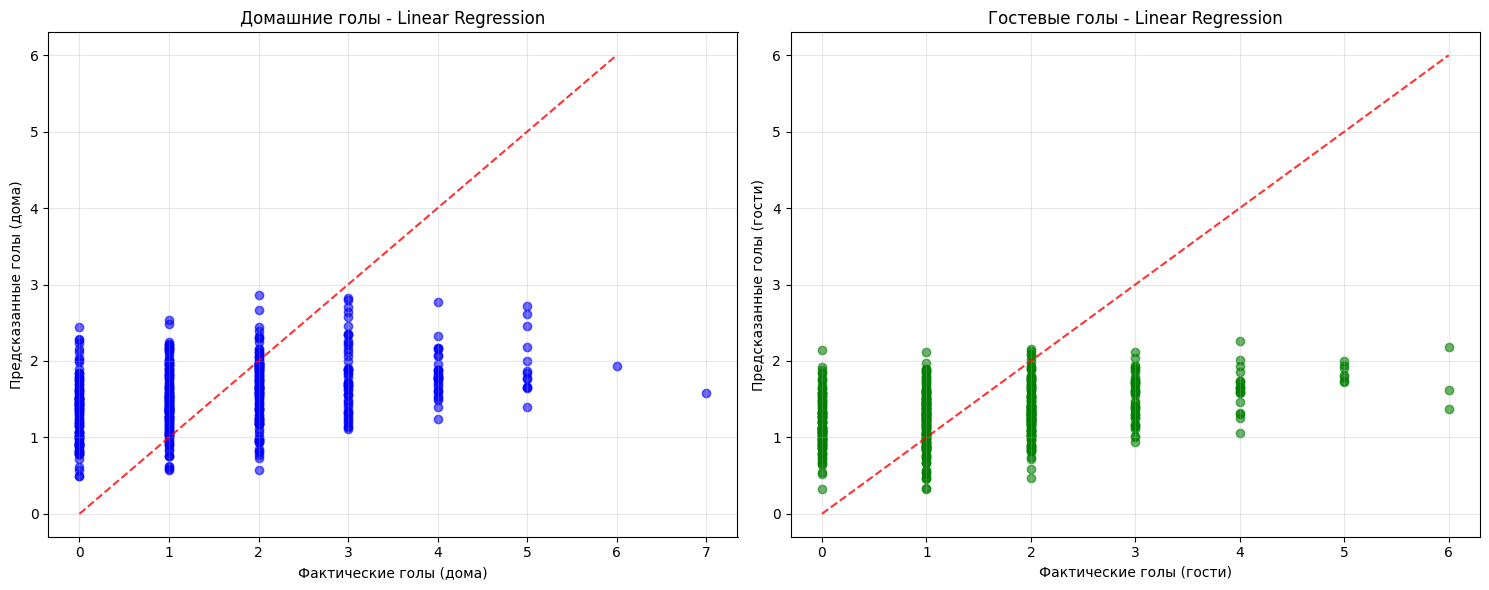

📊 Статистика предсказаний (Linear Regression):
   Домашние голы - MAE: 0.9706
   Гостевые голы - MAE: 0.8869
   Средний MAE: 0.9288

🔍 АНАЛИЗ КОРРЕЛЯЦИИ ПРИЗНАКОВ:

🔗 КОРРЕЛЯЦИЯ ПРИЗНАКОВ (ТОЛЬКО ТЕ, ЧТО ИСПОЛЬЗОВАЛИСЬ В МОДЕЛЯХ)
📊 Анализируется 9 признаков, использованных в моделях:
    1. Home_Form_Goals_For
    2. Home_Form_Goals_Against
    3. Away_Form_Goals_For
    4. Away_Form_Goals_Against
    5. H2H_Home_Avg
    6. H2H_Away_Avg
    7. ELO_Difference
    8. Form_Difference
    9. Goal_Difference_Ratio

🎯 ТОП-5 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ С РЕЗУЛЬТАТОМ
--------------------------------------------------
+-----+---------------------+---------------+------------+------------+
|   # | Признак             |   Ср.важность | Домашние   | Гостевые   |
+=====+=====================+===============+============+============+
|   1 | ELO_Difference      |        0.2894 | 0.3001🟢   | -0.2788🔴  |
+-----+---------------------+---------------+------------+------------+
|   2 | Form_Difference     |

In [ ]:
results_df, predictions, features_df, feature_names, best_model_name, X_test, y_test_home, y_test_away = run_full_analysis(6)
corr_matrix_1, config_name_1 = display_configuration_results(
    results_df, predictions, features_df, feature_names, best_model_name, 6
)



🏴󠁧󠁢󠁥󠁮󠁧󠁿 СИМУЛЯЦИЯ СЕЗОНА АПЛ: 2024-25
📊 Найдено матчей сезона 2024-25: 380
🔮 Получено предсказаний для симуляции: 380
⚽ Симулируем матчи сезона 2024-25...

🏆 ТАБЛИЦА АПЛ СЕЗОНА 2024-25 (СИМУЛЯЦИЯ)
🤖 Модель: Linear Regression
--------------------------------------------------------------------------------
+-------+----------------+-----+-----+-----+-----+------+------+------+-----+
|   Поз | Команда        |   И |   В |   Н |   П |   ГЗ |   ГП |   РГ |   О |
+=======+================+=====+=====+=====+=====+======+======+======+=====+
|     1 | Liverpool      |  38 |  36 |   0 |   2 |   78 |   35 |   43 | 108 |
+-------+----------------+-----+-----+-----+-----+------+------+------+-----+
|     2 | Arsenal        |  38 |  34 |   1 |   3 |   74 |   40 |   34 | 103 |
+-------+----------------+-----+-----+-----+-----+------+------+------+-----+
|     3 | Man City       |  38 |  33 |   4 |   1 |   72 |   38 |   34 | 103 |
+-------+----------------+-----+-----+-----+-----+------+------+-----

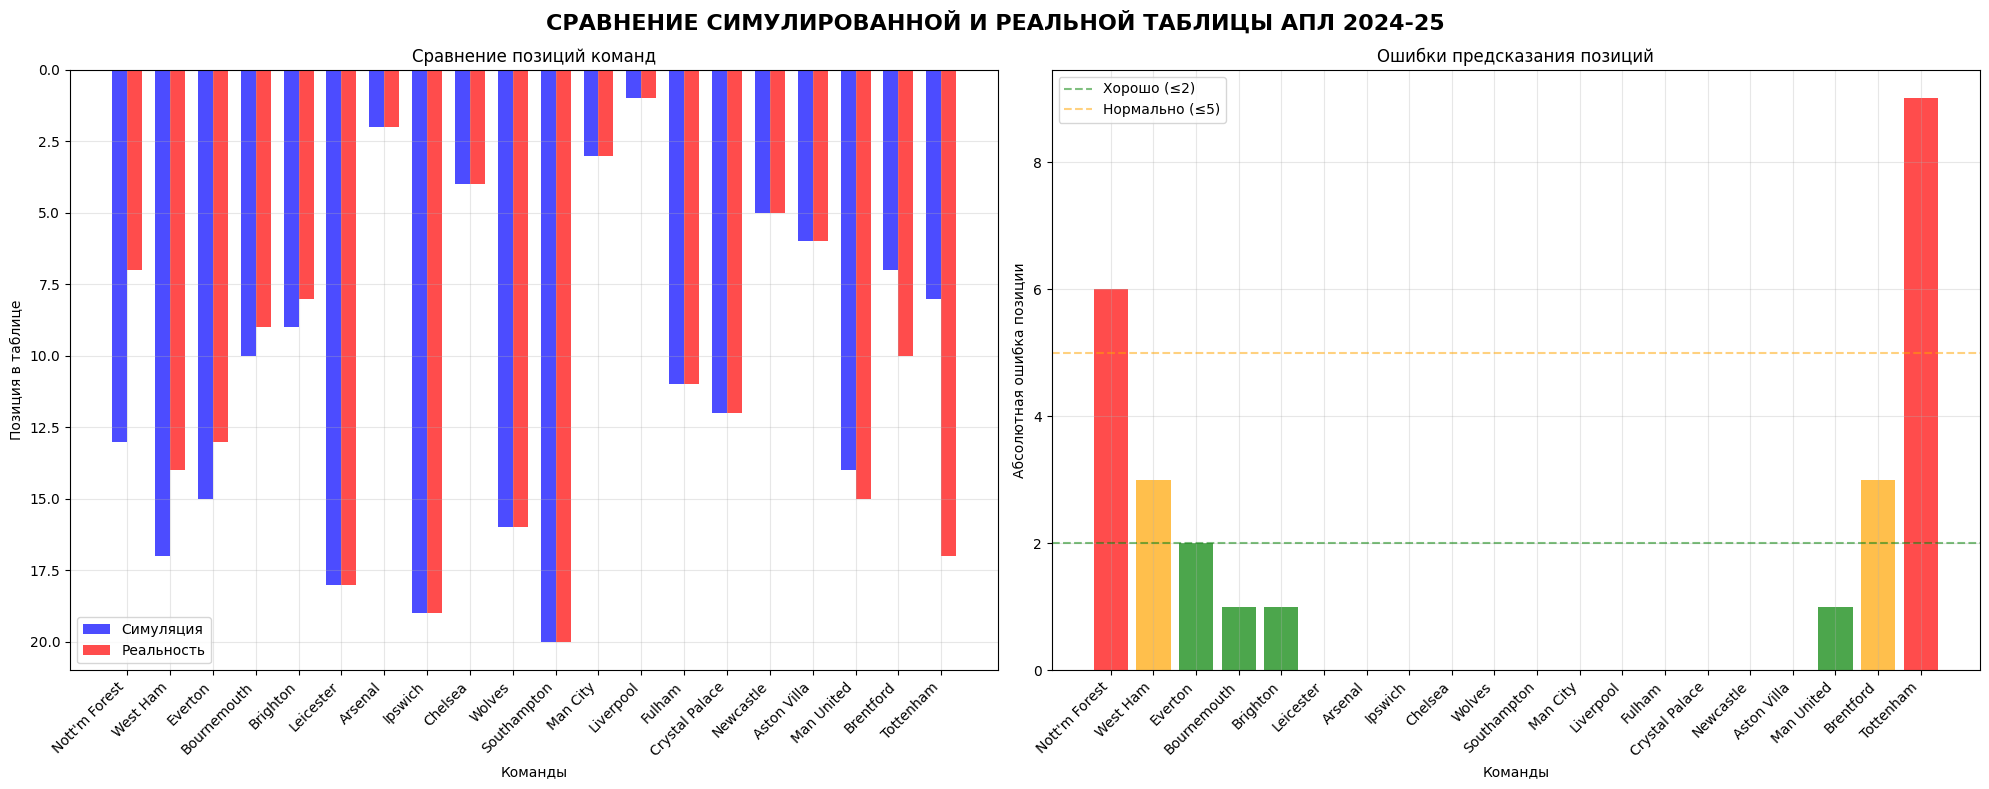

In [ ]:
def simulate_premier_league_season(results_df, predictions, features_df, best_model_name, target_season):
    """
    Симулирует сезон АПЛ на основе предсказаний Linear Regression
    """
    print(f"\n{'='*80}")
    print(f"🏴󠁧󠁢󠁥󠁮󠁧󠁿 СИМУЛЯЦИЯ СЕЗОНА АПЛ: {target_season}")
    print(f"{'='*80}")

    # 1. Находим тестовые данные для целевого сезона
    dates = features_df['Date'].sort_values()
    split_idx = int(len(dates) * 0.8)
    split_date = dates.iloc[split_idx]

    # Фильтруем матчи целевого сезона в тестовой выборке
    season_matches = features_df[
        (features_df['season'] == target_season) &
        (features_df['Date'] >= split_date)
    ].copy()

    if season_matches.empty:
        print(f"❌ Нет данных для сезона {target_season} в тестовой выборке")
        print(f"   Доступные сезоны в тестовой выборке: {features_df[features_df['Date'] >= split_date]['season'].unique()}")
        return None

    print(f"📊 Найдено матчей сезона {target_season}: {len(season_matches)}")

    # 2. Получаем предсказания для этих матчей
    pred_home = predictions['home'][best_model_name]
    pred_away = predictions['away'][best_model_name]

    # Получаем все тестовые данные
    test_mask = features_df['Date'] >= split_date
    test_data = features_df[test_mask].copy().reset_index(drop=True)

    # Обрезаем до одинакового размера
    min_len = min(len(pred_home), len(test_data))
    pred_home = pred_home[:min_len]
    pred_away = pred_away[:min_len]
    test_data = test_data.iloc[:min_len]

    # Создаем DataFrame с предсказаниями
    predictions_df = test_data[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'season']].copy()
    predictions_df['Pred_FTHG'] = pred_home
    predictions_df['Pred_FTAG'] = pred_away

    # 3. Фильтруем только целевой сезон
    season_predictions = predictions_df[predictions_df['season'] == target_season].copy()

    if season_predictions.empty:
        print(f"❌ Нет предсказаний для сезона {target_season}")
        return None

    print(f"🔮 Получено предсказаний для симуляции: {len(season_predictions)}")

    # 4. Округляем предсказания до целых чисел (реальные счета)
    season_predictions['Sim_FTHG'] = np.round(season_predictions['Pred_FTHG']).astype(int)
    season_predictions['Sim_FTAG'] = np.round(season_predictions['Pred_FTAG']).astype(int)

    # Защита от отрицательных голов (не может быть в реальности)
    season_predictions['Sim_FTHG'] = season_predictions['Sim_FTHG'].clip(lower=0)
    season_predictions['Sim_FTAG'] = season_predictions['Sim_FTAG'].clip(lower=0)

    # 5. Создаем таблицу для учета статистики команд
    teams = list(set(season_predictions['HomeTeam'].unique()) | set(season_predictions['AwayTeam'].unique()))

    # Инициализируем статистику команд
    league_table = {}
    for team in teams:
        league_table[team] = {
            'И': 0,      # Игры
            'В': 0,      # Победы
            'Н': 0,      # Ничьи
            'П': 0,      # Поражения
            'ГЗ': 0,     # Голов забито
            'ГП': 0,     # Голов пропущено
            'О': 0,      # Очки
            'РГ': 0      # Разница голов
        }

    # 6. Симулируем все матчи сезона
    print(f"⚽ Симулируем матчи сезона {target_season}...")

    for _, match in season_predictions.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        home_goals = match['Sim_FTHG']
        away_goals = match['Sim_FTAG']

        # Обновляем статистику для домашней команды
        league_table[home_team]['И'] += 1
        league_table[home_team]['ГЗ'] += home_goals
        league_table[home_team]['ГП'] += away_goals
        league_table[home_team]['РГ'] = league_table[home_team]['ГЗ'] - league_table[home_team]['ГП']

        # Обновляем статистику для гостевой команды
        league_table[away_team]['И'] += 1
        league_table[away_team]['ГЗ'] += away_goals
        league_table[away_team]['ГП'] += home_goals
        league_table[away_team]['РГ'] = league_table[away_team]['ГЗ'] - league_table[away_team]['ГП']

        # Определяем результат матча
        if home_goals > away_goals:
            # Победа домашней команды
            league_table[home_team]['В'] += 1
            league_table[home_team]['О'] += 3
            league_table[away_team]['П'] += 1
        elif home_goals < away_goals:
            # Победа гостевой команды
            league_table[away_team]['В'] += 1
            league_table[away_team]['О'] += 3
            league_table[home_team]['П'] += 1
        else:
            # Ничья
            league_table[home_team]['Н'] += 1
            league_table[home_team]['О'] += 1
            league_table[away_team]['Н'] += 1
            league_table[away_team]['О'] += 1

    # 7. Создаем итоговую таблицу
    table_data = []
    for team, stats in league_table.items():
        table_data.append({
            'Команда': team,
            'И': stats['И'],
            'В': stats['В'],
            'Н': stats['Н'],
            'П': stats['П'],
            'ГЗ': stats['ГЗ'],
            'ГП': stats['ГП'],
            'РГ': stats['РГ'],
            'О': stats['О']
        })

    # Сортируем по очкам, затем по разнице голов, затем по забитым голам
    final_table = pd.DataFrame(table_data)
    final_table = final_table.sort_values(['О', 'РГ', 'ГЗ'], ascending=[False, False, False])
    final_table = final_table.reset_index(drop=True)
    final_table['Поз'] = final_table.index + 1

    # 8. Выводим результаты
    print(f"\n🏆 ТАБЛИЦА АПЛ СЕЗОНА {target_season} (СИМУЛЯЦИЯ)")
    print(f"🤖 Модель: Linear Regression")
    print("-" * 80)

    # Форматируем таблицу для красивого вывода
    display_table = final_table[['Поз', 'Команда', 'И', 'В', 'Н', 'П', 'ГЗ', 'ГП', 'РГ', 'О']].copy()

    print(tabulate(display_table,
                  headers=['Поз', 'Команда', 'И', 'В', 'Н', 'П', 'ГЗ', 'ГП', 'РГ', 'О'],
                  tablefmt='grid',
                  showindex=False))

    # 9. Сравнение с реальной таблицей (если есть реальные данные)
    print(f"\n📊 СРАВНЕНИЕ С РЕАЛЬНЫМИ РЕЗУЛЬТАТАМИ:")

    # Считаем реальную таблицу на основе фактических результатов
    real_table = {}
    for team in teams:
        real_table[team] = {
            'И': 0, 'В': 0, 'Н': 0, 'П': 0,
            'ГЗ': 0, 'ГП': 0, 'О': 0, 'РГ': 0
        }

    for _, match in season_predictions.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        home_goals = match['FTHG']
        away_goals = match['FTAG']

        # Обновляем реальную статистику
        real_table[home_team]['И'] += 1
        real_table[home_team]['ГЗ'] += home_goals
        real_table[home_team]['ГП'] += away_goals
        real_table[home_team]['РГ'] = real_table[home_team]['ГЗ'] - real_table[home_team]['ГП']

        real_table[away_team]['И'] += 1
        real_table[away_team]['ГЗ'] += away_goals
        real_table[away_team]['ГП'] += home_goals
        real_table[away_team]['РГ'] = real_table[away_team]['ГЗ'] - real_table[away_team]['ГП']

        if home_goals > away_goals:
            real_table[home_team]['В'] += 1
            real_table[home_team]['О'] += 3
            real_table[away_team]['П'] += 1
        elif home_goals < away_goals:
            real_table[away_team]['В'] += 1
            real_table[away_team]['О'] += 3
            real_table[home_team]['П'] += 1
        else:
            real_table[home_team]['Н'] += 1
            real_table[home_team]['О'] += 1
            real_table[away_team]['Н'] += 1
            real_table[away_team]['О'] += 1

    # Создаем реальную таблицу
    real_table_data = []
    for team, stats in real_table.items():
        real_table_data.append({
            'Команда': team,
            'И': stats['И'],
            'В': stats['В'],
            'Н': stats['Н'],
            'П': stats['П'],
            'ГЗ': stats['ГЗ'],
            'ГП': stats['ГП'],
            'РГ': stats['РГ'],
            'О': stats['О']
        })

    real_table_df = pd.DataFrame(real_table_data)
    real_table_df = real_table_df.sort_values(['О', 'РГ', 'ГЗ'], ascending=[False, False, False])
    real_table_df = real_table_df.reset_index(drop=True)
    real_table_df['Поз'] = real_table_df.index + 1

    print(f"\n🏆 РЕАЛЬНАЯ ТАБЛИЦА АПЛ СЕЗОНА {target_season}")
    print("-" * 80)

    real_display = real_table_df[['Поз', 'Команда', 'И', 'В', 'Н', 'П', 'ГЗ', 'ГП', 'РГ', 'О']].copy()
    print(tabulate(real_display,
                  headers=['Поз', 'Команда', 'И', 'В', 'Н', 'П', 'ГЗ', 'ГП', 'РГ', 'О'],
                  tablefmt='grid',
                  showindex=False))

    # 10. Сравниваем позиции команд
    print(f"\n📈 СРАВНЕНИЕ ПОЗИЦИЙ КОМАНД:")

    comparison_data = []
    for team in teams:
        sim_pos = final_table[final_table['Команда'] == team]['Поз'].iloc[0]
        real_pos = real_table_df[real_table_df['Команда'] == team]['Поз'].iloc[0]
        diff = real_pos - sim_pos  # положительное = модель переоценила, отрицательное = недооценила

        comparison_data.append({
            'Команда': team,
            'Симуляция': sim_pos,
            'Реальность': real_pos,
            'Разница': diff,
            'Оценка': '✅ Точное попадание' if abs(diff) <= 2 else '⚠️ Небольшое отклонение' if abs(diff) <= 5 else '❌ Большое отклонение'
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Разница')

    print(tabulate(comparison_df,
                  headers=['Команда', 'Симуляция', 'Реальность', 'Разница', 'Оценка'],
                  tablefmt='grid',
                  showindex=False))

    # 11. Статистика точности
    position_errors = [abs(row['Разница']) for _, row in comparison_df.iterrows()]
    mae_positions = np.mean(position_errors)

    print(f"\n📊 СТАТИСТИКА ТОЧНОСТИ СИМУЛЯЦИИ:")
    print(f"   • Средняя ошибка позиций: {mae_positions:.2f}")
    print(f"   • Точных попаданий (±0 позиций): {len([x for x in position_errors if x == 0])}")
    print(f"   • Близких предсказаний (±1-2 позиции): {len([x for x in position_errors if 1 <= x <= 2])}")
    print(f"   • Средних ошибок (±3-5 позиций): {len([x for x in position_errors if 3 <= x <= 5])}")
    print(f"   • Больших ошибок (>5 позиций): {len([x for x in position_errors if x > 5])}")

    # 12. Визуализация сравнения
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'СРАВНЕНИЕ СИМУЛИРОВАННОЙ И РЕАЛЬНОЙ ТАБЛИЦЫ АПЛ {target_season}', fontsize=16, fontweight='bold')

    # График 1: Сравнение позиций
    teams_ordered = comparison_df['Команда'].tolist()
    sim_positions = [final_table[final_table['Команда'] == team]['Поз'].iloc[0] for team in teams_ordered]
    real_positions = [real_table_df[real_table_df['Команда'] == team]['Поз'].iloc[0] for team in teams_ordered]

    x = range(len(teams_ordered))
    width = 0.35

    ax1.bar([i - width/2 for i in x], sim_positions, width, label='Симуляция', alpha=0.7, color='blue')
    ax1.bar([i + width/2 for i in x], real_positions, width, label='Реальность', alpha=0.7, color='red')

    ax1.set_xlabel('Команды')
    ax1.set_ylabel('Позиция в таблице')
    ax1.set_title('Сравнение позиций команд')
    ax1.set_xticks(x)
    ax1.set_xticklabels(teams_ordered, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()  # Чтобы 1 место было наверху

    # График 2: Ошибки позиций
    errors = [abs(sim - real) for sim, real in zip(sim_positions, real_positions)]
    colors = ['green' if e <= 2 else 'orange' if e <= 5 else 'red' for e in errors]

    ax2.bar(teams_ordered, errors, color=colors, alpha=0.7)
    ax2.set_xlabel('Команды')
    ax2.set_ylabel('Абсолютная ошибка позиции')
    ax2.set_title('Ошибки предсказания позиций')
    ax2.set_xticklabels(teams_ordered, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)

    # Добавляем горизонтальные линии для ориентиров
    ax2.axhline(y=2, color='green', linestyle='--', alpha=0.5, label='Хорошо (≤2)')
    ax2.axhline(y=5, color='orange', linestyle='--', alpha=0.5, label='Нормально (≤5)')
    ax2.legend()

    plt.tight_layout()
    plt.show()
simulate_premier_league_season(results_df, predictions, features_df, 'Linear Regression', '2024-25')